In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output


%matplotlib inline


In [2]:
cd /Users/austinmcdonald/Desktop/test/cut/

/Users/austinmcdonald/Desktop/test/cut


In [3]:
DataSet = os.listdir()
DataSet = [x for x in DataSet if x != '.DS_Store']
#DataSet = DataSet[0]
DataSet

['Ba', 'Ca', 'Na']

In [4]:
DataPath = '/Users/austinmcdonald/Desktop/test/cut'

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [36]:
eCoeff = 0.01160
eOffset= 1917
AreaFull = dict()
AreaCUT = dict()
PairsM = dict()
PairsA = dict()
AreaCUT2 = dict() 
PairsM2 = dict()
Bleached = dict()
INFO1 = dict()
INFO2 = dict()

LIFETIME= dict()
INTENSITY= dict()
AREA= dict()
AREAPRE=dict()
AREAPOST=dict()
AREASS=dict()
CHIR= dict()
MEAND= dict()
MEANI=dict()
MEANE=dict()
NUM=dict()
PPairs = []
for z in range(0,len(DataSet)):
    FoldPath = DataPath+'/'+DataSet[z]
    Folders = os.listdir(FoldPath)
    Folders = [x for x in Folders if x != '.DS_Store']
    
    AreaH=[]        # kill this ?
    AreaHH=[]       # kill this ?
    SpotAreaH = []  # kill this ?
    SpotAreaHH = [] # kill this ?
    SpotAreaHH2 = []# kill this ?
    PairsMade2 = [] # kill this ?
    Bleach = []     # kill this ?
    MASTERTau = []
    MASTERItn = []
    MASTERarea=[]
    MASTERchiRa=[]
    MASTERmeanD=[]
    MASTERareaSS=[]
    MASTERareaPre=[]
    MASTERareaPost=[]
    MASTERmeanI=[]
    MASTERmeanE=[]
    SPOTS=[]
    PairsMade = []
    Shape = 221
    xvs = np.arange(0,Shape)
    ##Means = []# kill this ?
    #Devs  = []# kill this ?
    neighborhood_size = 9
    Row = int(4) # define the area to take around the spots
    Col = int(4) # define the area to take around the spots
    for w in range(0,len(Folders)):
        folder = FoldPath+'/'+Folders[w]
        files = os.listdir(folder)
        files = [x for x in files if x != '.DS_Store']
        DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
        Datatot = DataSub
        fitts = []
        AllPairs =[]
        SpotInfo2 = []

        ImageB = []
        MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
        eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
        eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
        for x in range(700,750):
            Images = np.array(Image.open(folder+'/'+files[x]))
            Images = eCoeffM*(Images - eOffsetM)
            #Mfit = np.zeros(len(xvs)) # kill this ?
            ImageFit = []
            for y in range(0,Shape):
                coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
                ffit  = poly.polyval(xvs, coefs)
                ImageFit.append(ffit)
            MeanFit+=np.array(ImageFit)
        MeanFit = MeanFit/50


        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            DataSub += Images


        data = DataSub

        threshold = np.mean(data)+3*np.std(data)  #////////////////////////////////////////////////////////////

        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        Pairs = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            x.append(x_center)
            y_center = (dy.start + dy.stop - 1)/2    
            y.append(y_center)
            Pairs.append((x_center,y_center))
        for item in Pairs:
            if item not in AllPairs:
                AllPairs.append(item) 


        Images = None
        ImageB = None
        #data   = None
        Slices = None
        labeled= None
        num_objects=None

        ############################################################## 
        Xc=[]
        Yc=[]
        for qw in range(0,len(AllPairs)):
            XX = AllPairs[qw][0]
            YY = AllPairs[qw][1]
            if XX>10 and XX<210 and YY>10 and YY<210:
                Xc.append(XX)
                Yc.append(YY)
        #try:
            #Xc=[]
            #Yc=[]
            #for qw in range(0,len(AllPairs)):
                #XX = AllPairs[qw][0]
                #YY = AllPairs[qw][0]
                #if XX>10 and XX<210 and YY>10 and YY<210:
                    #Xc.append(XX)
                    #Yc.append(YY)
        #except ValueError:
            #break
            #Xc=0
            #Yc=0
            #AllPairs=0

        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            Images[Images < 0] = 0 

            SpotInfoHolder = []

            for we in range(0,len(Xc)):
                Xindex = int(Xc[we])
                Yindex = int(Yc[we])

                spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot = spot1[2:7,2:7]
                SpotRemove = np.zeros(5**2).reshape((5,5))
                spot2[2:7,2:7]=SpotRemove
                spotB = spot2

                ATot = spot.sum()
                ATotB = spot2.sum()
                SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

    ########################################################################################  

            clear_output()
            print('Finding all areas in dataset'+' '+str(z)) 
            print('Finding all areas in folder'+' '+str(w)) 
            print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

        Par = len(AllPairs)
        AVG = 5
        Mnumb = 5
        PairsMade=[]
        Tau = []
        Signal = []
        for x in range(0,Par):
            HoldArea = np.array(SpotInfo2[x::Par])[:,4]
            HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]*(25/56)
            aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
            aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
            vals =np.arange(0,len(aa))

            coefs = poly.polyfit(vals,aaB, 3)
            ffit  = poly.polyval(vals, coefs)
            Sig = np.array(aa-ffit)

            meanI = np.mean(Sig[:Mnumb])
            sigmaI = np.std(Sig[:Mnumb])
            meanE = np.mean(Sig[-Mnumb:])
            sigmaE = np.std(Sig[-Mnumb:])
            meanM = np.mean(Sig)
            T = len(Sig)
            tau = ((meanM - meanE)/(meanI -meanE))*T
            Tau.append(tau)
            Signal.append(Sig)

        Tau2 = []
        Offset = 5
        for x in range(0,Par):
            TauH = Tau[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau2.append(TauH)

        Tau3 = []
        Offset = 3
        for x in range(0,Par):
            TauH = Tau2[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau3.append(TauH)
            

        #data = []
        #PairsMade = []
        #chiF = []
        #chiB = []
        #chiFIT=[]
        chiRa = []
        meanDif = []
        #Dtau = []
        areaS=[]
        areaSS=[]
        areaPre=[]
        areaPost=[]
        ITEN=[]
        MeanI=[]
        MeanE=[]
        Offset =3
        NUMBER = 0
        for x in range(0,Par):
            TauH   = Tau3[x]
            Data = running_mean(Signal[x],4)
            DataLeft  = Data[:int(TauH)-Offset]
            DataRight = Data[int(TauH)+Offset:]
            sigma = np.std(Data)
            mean  = np.mean(Data)
            meanI  = np.mean(DataLeft)
            sigmaI = np.std(DataLeft)
            meanE  = np.mean(DataRight)
            sigmaE = np.std(DataRight)
            Inten  = Signal[x][:int(TauH)]
            Intensity  = np.sum(Inten)/len(Inten)#######  mean? wtf man
            chiHIGH = np.sum((DataLeft - np.mean(DataLeft))**2)
            chiLOW = np.sum((DataRight - np.mean(DataRight))**2)
            val = np.arange(0,len(Data),1)
            fit=np.polyfit(val,Data,1)    
            chiFit  = np.sum((np.polyval(fit, val) - Data) ** 2)
            ###dtau = TauH*np.sqrt(((sigma-sigmaE)/(mean-meanE))**2+((sigmaI-sigmaE)/(meanI-meanE))**2)
            #data.append([Signal[x],TauH,Intensity])
            #PairsMade.append(AllPairs[x])
            #chiF.append(chiHIGH)
            #chiB.append(chiLOW)
            #chiFIT.append(chiFit)
            ##ITEN.append(Intensity)
            
            if meanI-meanE>20 and ((chiLOW+chiHIGH)/ chiFit)<1:
                NUMBER += 1
            
            ##chiRa.append((chiLOW+chiHIGH)/ chiFit)
            ##meanDif.append(meanI-meanE)
            ###Dtau.append(dtau)
            ##areaS.append(Signal[x])
            ##areaSS.append(Data)
            ##areaPre.append(DataLeft)
            ##areaPost.append(DataRight)
            ##MeanI.append(meanI)
            ##MeanE.append(meanE)
        SPOTS.append(NUMBER)
        ##MASTERTau.append(Tau3)
        ##MASTERItn.append(ITEN)
        ##MASTERarea.append(areaS)
        ##MASTERareaSS.append(areaSS)
        ##MASTERareaPre.append(areaPre)
        ##MASTERareaPost.append(areaPost)

        ##MASTERchiRa.append(chiRa)
        ##MASTERmeanD.append(meanDif)
        ##MASTERmeanI.append(MeanI)
        ##MASTERmeanE.append(MeanE)
    NUM[z] =     SPOTS#[item for sublist in SPOTS for item in sublist]
    ##MEANI[z] = [item for sublist in MASTERmeanI for item in sublist] 
    ##MEANE[z] = [item for sublist in MASTERmeanE for item in sublist]
    ##LIFETIME[z] = [item for sublist in MASTERTau for item in sublist]
    ##INTENSITY[z]= [item for sublist in MASTERItn for item in sublist]
    ##AREA[z]     = [item for sublist in MASTERarea for item in sublist]
    ##AREAPRE[z]  = [item for sublist in MASTERareaPre for item in sublist]
    ##AREAPOST[z] = [item for sublist in MASTERareaPost for item in sublist]

    ##AREASS[z]     = [item for sublist in MASTERareaSS for item in sublist]

    ##CHIR[z]     = [item for sublist in MASTERchiRa for item in sublist]
    ##MEAND[z]    = [item for sublist in MASTERmeanD for item in sublist]

    #AreaFull[z]  = [item for sublist in AreaHH for item in sublist]
    #AreaCUT[z]   = [item for sublist in SpotAreaHH for item in sublist]
    #PairsM[z]    = [item for sublist in PairsMade for item in sublist]
    #PairsA[z]    = [item for sublist in PPairs for item in sublist]
    #AreaCUT2[z]  = [item for sublist in SpotAreaHH2 for item in sublist]
    #PairsM2[z]   = [item for sublist in PairsMade2 for item in sublist]
    #Bleached[z]  = Bleach

Finding all areas in dataset 2
Finding all areas in folder 21
On file 750 of 750


In [28]:
for x in range(0,len(DataSet)):
    print(DataSet[x]+' '+' pairs = ',len(NUM[x]))

Ba  pairs =  22
Ca  pairs =  1
Na  pairs =  22


In [37]:
NUM[0]

[3, 0, 0, 3, 6, 9, 0, 11, 15, 12, 0, 18, 5, 11, 0, 0, 9, 5, 0, 0, 0, 11]

In [38]:
NUM[2]

[0, 1, 5, 6, 5, 0, 0, 0, 5, 1, 7, 3, 5, 0, 0, 0, 0, 2, 0, 4, 4, 7]

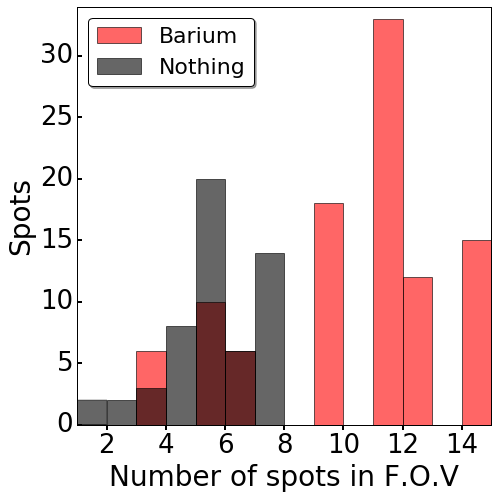

In [66]:

plt.figure(figsize=(7,7))
num =1
plt.hist(NUM[0],label='Barium',alpha=0.6,color='r',bins=np.arange(1,16,num),weights=NUM[0])
plt.hist(NUM[2],label='Nothing',alpha=0.6,color='k',bins=np.arange(1,16,num),weights=NUM[2])


plt.xlabel("Number of spots in F.O.V", fontsize=28)
plt.ylabel("Spots", fontsize=28)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
#plt.xticks([450,475,500,525,550,575,600,625],ha='left')
plt.tick_params(top="off",right='off')
plt.tick_params(axis='x', direction='out',width=2,length=5)
plt.tick_params(axis='y',width=2,length=5)
plt.legend(loc='upper left',fontsize=22,shadow=True, fancybox=True)
plt.xlim(1,15)
plt.ylim(0,34)

plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/FOVhist')
plt.show()

In [110]:
nbins = np.arange(0,6e3,num)
histba, bin_edgesba = np.histogram(AreaPass3[0] , nbins)
bin_centresba = (bin_edgesba[:-1] + bin_edgesba[1:])/2

histna, bin_edgesna = np.histogram(AreaPass3[2] , nbins)
bin_centresna = (bin_edgesna[:-1] + bin_edgesna[1:])/2

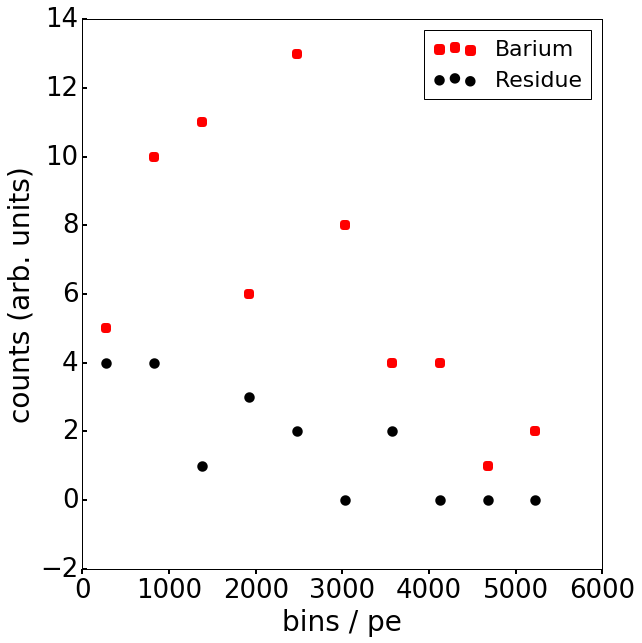

In [111]:
plt.figure(figsize=(9,9))
baerry = np.sqrt(histba)
naerry = np.sqrt(histna)

baerrx = (bin_centresba[1]-bin_centresba[0])/2
naerrx = (bin_centresna[1]-bin_centresna[0])/2

plt.scatter(bin_centresba,histba,linewidth=6,color='r',marker='s',label='Barium')
plt.scatter(bin_centresna,histna,linewidth=6,color='k',marker='o',label='Residue')

#plt.errorbar(bin_centresba,histba,yerr=baerry,xerr=baerrx,color='r',fmt='.')
#plt.errorbar(bin_centresna,histna,yerr=naerry,xerr=naerrx,color='k',fmt='.')

plt.xlabel(r'bins / pe', fontsize=28)
plt.ylabel('counts (arb. units)', fontsize=28)
plt.legend(loc='upper right',fontsize=22,shadow=True, fancybox=True)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
#plt.xticks([450,475,500,525,550,575,600,625],ha='left')
plt.tick_params(top="off",right='off')
plt.tick_params(axis='x', direction='out',width=2,length=5)
plt.tick_params(axis='y',width=2,length=5)


plt.xlim(0,6e3)
#plt.ylim(0,500)
#plt.axhline(0,linewidth=3,linestyle='--',color='k')

#plt.axvline(30)
plt.legend(fontsize=22)
plt.tight_layout()
#plt.savefig(SAVE+'Hist-areapre-meancor-lifeWgh')
plt.show()

In [ ]:
   '''

        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            Images[Images < 0] = 0 

            SpotInfoHolder = []

            for we in range(0,len(Xc)):
                Xindex = int(Xc[we])
                Yindex = int(Yc[we])

                spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot = spot1[2:7,2:7]
                SpotRemove = np.zeros(5**2).reshape((5,5))
                spot2[2:7,2:7]=SpotRemove
                spotB = spot2

                ATot = spot.sum()
                ATotB = spot2.sum()
                SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

    ########################################################################################  

            clear_output()
            print('Finding all areas in dataset'+' '+str(z)) 
            print('Finding all areas in folder'+' '+str(w)) 
            print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

        Par = len(AllPairs)
        AVG = 5
        Mnumb = 5
        PairsMade=[]
        Tau = []
        Signal = []
        for x in range(0,Par):
            HoldArea = np.array(SpotInfo2[x::Par])[:,4]
            HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]*(25/56)
            aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
            aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
            vals =np.arange(0,len(aa))

            coefs = poly.polyfit(vals,aaB, 3)
            ffit  = poly.polyval(vals, coefs)
            Sig = np.array(aa-ffit)

            meanI = np.mean(Sig[:Mnumb])
            sigmaI = np.std(Sig[:Mnumb])
            meanE = np.mean(Sig[-Mnumb:])
            sigmaE = np.std(Sig[-Mnumb:])
            meanM = np.mean(Sig)
            T = len(Sig)
            tau = ((meanM - meanE)/(meanI -meanE))*T
            Tau.append(tau)
            Signal.append(Sig)

        Tau2 = []
        Offset = 5
        for x in range(0,Par):
            TauH = Tau[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau2.append(TauH)

        Tau3 = []
        Offset = 3
        for x in range(0,Par):
            TauH = Tau2[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau3.append(TauH)
            

        #data = []
        #PairsMade = []
        #chiF = []
        #chiB = []
        #chiFIT=[]
        chiRa = []
        meanDif = []
        #Dtau = []
        areaS=[]
        areaSS=[]
        areaPre=[]
        areaPost=[]
        ITEN=[]
        MeanI=[]
        MeanE=[]
        Offset =3
        NUMBER = 0
        for x in range(0,Par):
            TauH   = Tau3[x]
            Data = running_mean(Signal[x],4)
            DataLeft  = Data[:int(TauH)-Offset]
            DataRight = Data[int(TauH)+Offset:]
            sigma = np.std(Data)
            mean  = np.mean(Data)
            meanI  = np.mean(DataLeft)
            sigmaI = np.std(DataLeft)
            meanE  = np.mean(DataRight)
            sigmaE = np.std(DataRight)
            Inten  = Signal[x][:int(TauH)]
            Intensity  = np.sum(Inten)/len(Inten)#######  mean? wtf man
            chiHIGH = np.sum((DataLeft - np.mean(DataLeft))**2)
            chiLOW = np.sum((DataRight - np.mean(DataRight))**2)
            val = np.arange(0,len(Data),1)
            fit=np.polyfit(val,Data,1)    
            chiFit  = np.sum((np.polyval(fit, val) - Data) ** 2)
            ###dtau = TauH*np.sqrt(((sigma-sigmaE)/(mean-meanE))**2+((sigmaI-sigmaE)/(meanI-meanE))**2)
            #data.append([Signal[x],TauH,Intensity])
            #PairsMade.append(AllPairs[x])
            #chiF.append(chiHIGH)
            #chiB.append(chiLOW)
            #chiFIT.append(chiFit)
            ##ITEN.append(Intensity)
            
            if meanI-meanE>25 and ((chiLOW+chiHIGH)/ chiFit)<1:
                NUMBER += 1
            
            ##chiRa.append((chiLOW+chiHIGH)/ chiFit)
            ##meanDif.append(meanI-meanE)
            ###Dtau.append(dtau)
            ##areaS.append(Signal[x])
            ##areaSS.append(Data)
            ##areaPre.append(DataLeft)
            ##areaPost.append(DataRight)
            ##MeanI.append(meanI)
            ##MeanE.append(meanE)
        SPOTS.append(NUMBER)
        ##MASTERTau.append(Tau3)
        ##MASTERItn.append(ITEN)
        ##MASTERarea.append(areaS)
        ##MASTERareaSS.append(areaSS)
        ##MASTERareaPre.append(areaPre)
        ##MASTERareaPost.append(areaPost)

        ##MASTERchiRa.append(chiRa)
        ##MASTERmeanD.append(meanDif)
        ##MASTERmeanI.append(MeanI)
        ##MASTERmeanE.append(MeanE)
    NUM[z] =     SPOTS#[item for sublist in SPOTS for item in sublist]
    ##MEANI[z] = [item for sublist in MASTERmeanI for item in sublist] 
    ##MEANE[z] = [item for sublist in MASTERmeanE for item in sublist]
    ##LIFETIME[z] = [item for sublist in MASTERTau for item in sublist]
    ##INTENSITY[z]= [item for sublist in MASTERItn for item in sublist]
    ##AREA[z]     = [item for sublist in MASTERarea for item in sublist]
    ##AREAPRE[z]  = [item for sublist in MASTERareaPre for item in sublist]
    ##AREAPOST[z] = [item for sublist in MASTERareaPost for item in sublist]

    ##AREASS[z]     = [item for sublist in MASTERareaSS for item in sublist]

    ##CHIR[z]     = [item for sublist in MASTERchiRa for item in sublist]
    ##MEAND[z]    = [item for sublist in MASTERmeanD for item in sublist]

    #AreaFull[z]  = [item for sublist in AreaHH for item in sublist]
    #AreaCUT[z]   = [item for sublist in SpotAreaHH for item in sublist]
    #PairsM[z]    = [item for sublist in PairsMade for item in sublist]
    #PairsA[z]    = [item for sublist in PPairs for item in sublist]
    #AreaCUT2[z]  = [item for sublist in SpotAreaHH2 for item in sublist]
    #PairsM2[z]   = [item for sublist in PairsMade2 for item in sublist]
    #Bleached[z]  = Bleach'''
        